# Finding Causality in Big Data

## Import required libraries and data

In [70]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import binom, hypergeom, gaussian_kde
from scipy.stats import ttest_ind
import math
from numpy import linalg
import scipy.spatial.distance as ssdist
import statsmodels.genmod.generalized_linear_model as sm
import warnings
warnings.filterwarnings("ignore")

# Attributes:

* school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
* sex - student's sex (binary: "F" - female or "M" - male)
* age - student's age (numeric: from 15 to 22)
* address - student's home address type (binary: "U" - urban or "R" - rural)
* famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
* Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
* Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
* Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
* Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
* Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
* reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
* guardian - student's guardian (nominal: "mother", "father" or "other")
* traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
* studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
* failures - number of past class failures (numeric: n if 1<=n<3, else 4)
* schoolsup - extra educational support (binary: yes or no)
* famsup - family educational support (binary: yes or no)
* paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
* activities - extra-curricular activities (binary: yes or no)
* nursery - attended nursery school (binary: yes or no)
* higher - wants to take higher education (binary: yes or no)
* internet - Internet access at home (binary: yes or no)
* romantic - with a romantic relationship (binary: yes or no)
* famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
* freetime - free time after school (numeric: from 1 - very low to 5 - very high)
* goout - going out with friends (numeric: from 1 - very low to 5 - very high)
* Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
* Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
* health - current health status (numeric: from 1 - very bad to 5 - very good)
* absences - number of school absences (numeric: from 0 to 93)

### These grades are related with the course subject, Math or Portuguese:
* G1 - first period grade (numeric: from 0 to 20)
* G2 - second period grade (numeric: from 0 to 20)
* G3 - final grade (numeric: from 0 to 20, output target)

In [71]:
# 1. read data
df = pd.read_csv("../Data/student-mat.csv",sep= ";").drop(['G1','G2'],1)
print(df.columns)
print(df.shape) 
df.head()

Index([u'school', u'sex', u'age', u'address', u'famsize', u'Pstatus', u'Medu',
       u'Fedu', u'Mjob', u'Fjob', u'reason', u'guardian', u'traveltime',
       u'studytime', u'failures', u'schoolsup', u'famsup', u'paid',
       u'activities', u'nursery', u'higher', u'internet', u'romantic',
       u'famrel', u'freetime', u'goout', u'Dalc', u'Walc', u'health',
       u'absences', u'G3'],
      dtype='object')
(395, 31)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,10


In [72]:
# 2. convert all attributes into integer
# to do: store mappings for each attribute in a dictionary
for col in df:
    if (df[col].dtypes == object) == True:
        new_map = dict(zip(df[col].unique(),range(len(df[col].unique()))))
        df[col] = df[col].map(new_map)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,0,0,18,0,0,0,4,4,0,0,...,0,0,4,3,4,1,1,3,6,6
1,0,0,17,0,0,1,1,1,0,1,...,1,0,5,3,3,1,1,3,4,6
2,0,0,15,0,1,1,1,1,0,1,...,1,0,4,3,2,2,3,3,10,10
3,0,0,15,0,0,1,4,2,1,2,...,1,1,3,2,2,1,1,5,2,15
4,0,0,16,0,0,1,3,3,2,1,...,0,0,4,3,2,1,2,5,4,10


* Outcome: Final grade
* Treatment: paid - extra paid classes within the course subject (binary: yes or no)
* Covariates: all the other attributes

## Define treatment, outcome and covariates

In [73]:
# treatment
TREAT = 'paid'
Tr = df[TREAT]

# outcome
OUT = 'G3'

# 1 Identify covariates from observational data
## 1.1 Difference-in-means: outcome variable

* Effectiveness of treatment (effect on RE78 expression)
* Question: does treatment affect RE78 expression (outcome)?

In [74]:
# t-statistic & p-value for difference in outcome of two groups
def hypothesisTest(data, attribute, group):
    x = data[attribute][df[group]== 1]
    y = data[attribute][df[group]== 0]
    # t-statistic & p-value for difference in outcome of two groups
    t = ttest_ind(x, y)[0]
    p = ttest_ind(x, y)[1]
    # Confidence intervals
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    CI = str(round(cm.tconfint_diff(usevar='unequal')[0]))+' - '+str(round(cm.tconfint_diff(usevar='unequal')[1]))
    # Cohen's d
    pooledvar = math.sqrt((pow(x.std(),2) + (pow(y.std(),2)))/2)
    d = (x.mean()-y.mean()) / pooledvar
    # create dataframe
    tablelist = []
    tablerow = [attribute,x.mean()-y.mean(),t,p,CI,d]
    tablelist.append(tablerow)
    out = pd.DataFrame(tablelist)
    out.columns = ['Attribute','Mean Difference','t-value','p-value','95% Confidence Intervals',"Cohen's d"]

    return out

In [75]:
df.groupby(TREAT).size()

paid
0    214
1    181
dtype: int64

In [76]:
df.groupby(TREAT)[OUT].mean().reset_index()

,paid,G3
0,0,9.985981
1,1,10.922652


In [77]:
hypothesisTest(df, 'G3', 'paid')

,Attribute,Mean Difference,t-value,p-value,95% Confidence Intervals,Cohen's d
0,G3,0.936671,2.032597,0.042765,0.0 - 2.0,0.207768


#### There is a 5% increase in outcome for treated group and the difference is significant.

In [78]:
# covariates
b = pd.DataFrame()
for att in df.drop([TREAT,OUT],1):
    a = []
    a = hypothesisTest(df, att, TREAT)
    b = pd.concat([b,a],0)
b.sort_values('p-value')

,Attribute,Mean Difference,t-value,p-value,95% Confidence Intervals,Cohen's d
0,famsup,0.286647,6.079302,2.859350e-09,0.0 - 0.0,0.618191
0,higher,-0.083260,-3.820024,1.550372e-04,-0.0 - -0.0,-0.399646
0,failures,-0.280296,-3.795432,1.706341e-04,-0.0 - -0.0,-0.390132
0,studytime,0.281303,3.362348,8.486528e-04,0.0 - 0.0,0.339536
0,Medu,0.350441,3.207098,1.450621e-03,0.0 - 1.0,0.324368
0,internet,0.114654,3.071946,2.274716e-03,0.0 - 0.0,0.313990
0,reason,0.359658,2.919977,3.702216e-03,0.0 - 1.0,0.295635
0,sex,-0.129395,-2.581427,1.020069e-02,-0.0 - -0.0,-0.260863
0,nursery,-0.082770,-2.035559,4.246498e-02,-0.0 - -0.0,-0.206889
0,Mjob,0.237595,1.923337,5.515985e-02,-0.0 - 0.0,0.193711


In [79]:
# covariates
COV = np.array(b.Attribute[b['p-value'] <= 0.05])
X = df[COV]
X.head()

,sex,Medu,reason,studytime,failures,famsup,nursery,higher,internet
0,0,4,0,2,0,0,0,0,0
1,0,1,0,2,0,1,1,0,1
2,0,1,1,2,3,0,0,0,1
3,0,4,2,3,0,1,0,0,1
4,0,3,2,2,0,1,0,0,0


## 2.1 Propensity score matching

In [80]:
####### Using GLM
glm_binom = sm.GLM(Tr, X, family=sm.families.Binomial())
res = glm_binom.fit()
print res.summary()
propensityScoreGLM = res.fittedvalues
df_new = pd.concat([df[COV],df[OUT],propensityScoreGLM],1)
df_new.columns = np.append(COV, [OUT,'Propensity Score'], axis=None )
print '\n'+ 'Propensity Scores added: '
df_new.head()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   paid   No. Observations:                  395
Model:                            GLM   Df Residuals:                      386
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -241.41
Date:                Sun, 12 Nov 2017   Deviance:                       482.82
Time:                        21:44:34   Pearson chi2:                     383.
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex           -0.5361      0.222     -2.417      0.016      -0.971      -0.101
Medu          -0.1038      0.096     -1.078      0.2

,sex,Medu,reason,studytime,failures,famsup,nursery,higher,internet,G3,Propensity Score
0,0,4,0,2,0,0,0,0,0,6,0.330739
1,0,1,0,2,0,1,1,0,1,6,0.599279
2,0,1,1,2,3,0,0,0,1,10,0.162223
3,0,4,2,3,0,1,0,0,1,15,0.673137
4,0,3,2,2,0,1,0,0,0,10,0.643184


## Matching 

* optimal matching 
* greedy nearest neighbor matching without replacement
* greedy nearest neighbor matching without replacement within specified caliper widths
* nearest neighbor matching with replacement
* nearest neighbor matching with replacement within specified caliper widths

In [81]:
def Match(groups, propensity, caliper , replace = False):
        
    # Code groups as 0 and 1
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups[groups == 1].index; N2 = groups[groups == 0].index
    g1, g2 = propensity[groups == 1], propensity[groups == 0]
    # Check if treatment groups got flipped - the smaller should correspond to N1/g1
    if len(N1) > len(N2):
       N1, N2, g1, g2 = N2, N1, g2, g1
        
    # Randomly permute the smaller group to get order for matching
    morder = np.random.permutation(N1)
    matches = {}
    
    for m in morder:
        dist = abs(g1[m] - g2)
        if (dist.min() <= caliper) or not caliper:
            matches[m] = dist.argmin()    # Potential problem: check for ties
            if not replace:
                g2 = g2.drop(matches[m])
    return (matches)


def whichMatched(matches, data):
  
    tr = matches.keys()
    ctrl = matches.values()
    temp = pd.concat([data.iloc[tr], data.iloc[ctrl]])

    return temp

In [82]:
# one-to-one without caliper, without replacement
matches = Match(Tr, propensityScoreGLM, caliper = 0, replace = False)
temp = whichMatched(matches, df)

PS_matched = temp.groupby(temp.index).first()
PS_matched.groupby(TREAT).size().reset_index()

,paid,0
0,0,181
1,1,181


In [83]:
# Exercise: Run one-to-one matching with fixed 0.05 caliper, without replacement
matches = Match(Tr, propensityScoreGLM, caliper = 0.05, replace = False)
temp = whichMatched(matches, df)

PS_matched1 = temp.groupby(temp.index).first()
PS_matched1.groupby(TREAT).size().reset_index()

,paid,0
0,0,135
1,1,135


In [84]:
# Exercise: Run one-to-one matching with logit caliper, without replacement
matches = Match(Tr, propensityScoreGLM, caliper = 'logit', replace = False)
temp = whichMatched(matches, df)

PS_matched2 = temp.groupby(temp.index).first()
PS_matched2.groupby(TREAT).size().reset_index()

,paid,0
0,0,181
1,1,181


In [85]:
# Exercise: Run one-to-one matching with logit caliper, with replacement
matches = Match(Tr, propensityScoreGLM, caliper = 'logit', replace = True)
temp = whichMatched(matches, df)

PS_matched3 = temp.groupby(temp.index).first()
PS_matched3.groupby(TREAT).size().reset_index()

,paid,0
0,0,80
1,1,181


# 4 Evaluating matching methods

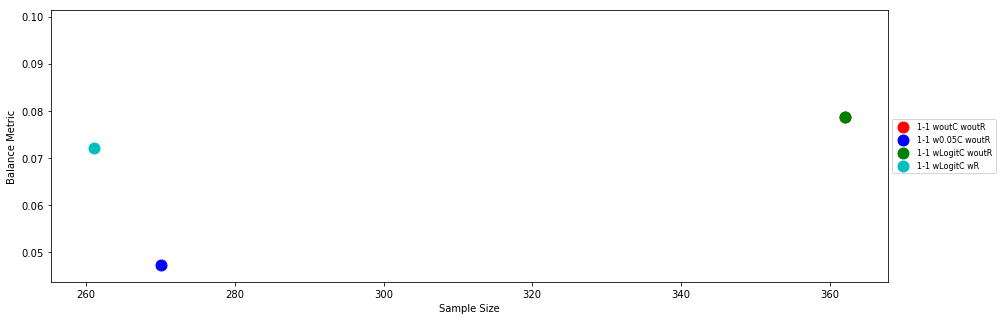

In [86]:
f = plt.figure(figsize=(15,5))

PS_matched_norm = (PS_matched[COV] - PS_matched[COV].mean()) / (PS_matched[COV].max() - PS_matched[COV].min())
PS_matched_mean = pd.DataFrame({'mean':abs(PS_matched_norm[PS_matched[TREAT]==1].mean() - PS_matched_norm[PS_matched[TREAT]==0].mean())}).mean()[0]

PS_matched_norm = (PS_matched1[COV] - PS_matched1[COV].mean()) / (PS_matched1[COV].max() - PS_matched1[COV].min())
PS_matched_mean1 = pd.DataFrame({'mean':abs(PS_matched_norm[PS_matched1[TREAT]==1].mean() - PS_matched_norm[PS_matched1[TREAT]==0].mean())}).mean()[0]

PS_matched_norm = (PS_matched2[COV] - PS_matched2[COV].mean()) / (PS_matched2[COV].max() - PS_matched2[COV].min())
PS_matched_mean2 = pd.DataFrame({'mean':abs(PS_matched_norm[PS_matched2[TREAT]==1].mean() - PS_matched_norm[PS_matched2[TREAT]==0].mean())}).mean()[0]

PS_matched_norm = (PS_matched3[COV] - PS_matched3[COV].mean()) / (PS_matched3[COV].max() - PS_matched3[COV].min())
PS_matched_mean3 = pd.DataFrame({'mean':abs(PS_matched_norm[PS_matched3[TREAT]==1].mean() - PS_matched_norm[PS_matched3[TREAT]==0].mean())}).mean()[0]

x = [PS_matched.shape[0],PS_matched1.shape[0],PS_matched2.shape[0],PS_matched3.shape[0]]
y = [PS_matched_mean ,PS_matched_mean1,PS_matched_mean2,PS_matched_mean3]
colors = ['r','b','g','c','k','m','y']
MatchingMethod = ['1-1 woutC woutR','1-1 w0.05C woutR','1-1 wLogitC woutR','1-1 wLogitC wR']

j = 0
for i in x:
    plt.scatter(i, y[j], s=120, c=colors[j], label=MatchingMethod[j])
    j += 1
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=1, fancybox=True, fontsize=8)
    plt.xlabel('Sample Size')
    plt.ylabel('Balance Metric')
plt.show()

* The comparison of sample size and balance between different matchings show that the Green dot that represents 1-1 matching with Logit caliper and without replacement gives the highest sample size while its balance competes with the blue dot by being only 0.03 higher. 
* Therefore, we use PS_matched2 as the prefered matched set.

## 5 Estimate treatment effects

Estimate average treatment effect  on the treated

### 5.1 Computes ATT using difference in means

In [87]:
# t-statistic & p-value for difference in outcome of two groups
def hypothesisTestOutcome(data, attribute, group):
    x = data[attribute][df[group]== 1]
    y = data[attribute][df[group]== 0]
    # t-statistic & p-value for difference in outcome of two groups
    t = ttest_ind(x, y)[0]
    p = ttest_ind(x, y)[1]
    # Confidence intervals
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    CI = str(round(cm.tconfint_diff(usevar='unequal')[0]))+' - '+str(round(cm.tconfint_diff(usevar='unequal')[1]))
    # Cohen's d
    pooledvar = math.sqrt((pow(x.std(),2) + (pow(y.std(),2)))/2)
    d = (x.mean()-y.mean()) / pooledvar
    # create dataframe
    tablelist = []
    tablerow = [attribute,x.mean()-y.mean(),((x.mean()-y.mean())/df[attribute].max()),t,p,d]
    tablelist.append(tablerow)
    out = pd.DataFrame(tablelist)
    out.columns = ['Attribute','Outcome Mean Difference','Outcome Mean Difference %','t-value','p-value',"Cohen's d"]

    return out

In [88]:
# Matched outcome
Y0_PS_matched = PS_matched2.G3[df.paid == 0]
Y1_PS_matched = PS_matched2.G3[df.paid == 1]

print 'Differene in means: '+ str((Y1_PS_matched.mean() - Y0_PS_matched.mean())) 

Differene in means: 0.364640883978


In [89]:
hypothesisTestOutcome(PS_matched2, 'G3', 'paid')

,Attribute,Outcome Mean Difference,Outcome Mean Difference %,t-value,p-value,Cohen's d
0,G3,0.364641,0.018232,0.779379,0.436269,0.081926


* We observe that the initial difference in score for students who took the paid classes and didn't is equal to 0.3 after matching, while it was close to 1 point score (out of 20) before matching.
* Therefore, we can conclude that the extra paid classes did not have an effect in impro